In [32]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn import preprocessing

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [33]:
n = 100
g = 1100
o = 100
k = 20

In [34]:
eta, lamb1, lamb2 = 0.053705, 0.013012, 0.007704
eta_nn, lamb1_nn, lamb2_nn = 0.053890, 0.015103, 0.0

In [35]:
def DFtoDataset(df, scale=False):
    X = df[[str(i) for i in np.arange(n)]].values.T
    if (scale):
        X = preprocessing.scale(X)
    y_cls = df['gene_group'].values[o:].astype(np.int32)
    binaryPathwayMatrix = np.zeros((g, k))
    binaryPathwayMatrix[np.arange(o, g), y_cls] = 1
    geneCoeffs = df[['coeff{}'.format(i) for i in range(o)]].values[o:, :]  

    return X, binaryPathwayMatrix, geneCoeffs

In [36]:
dataFileBase = '/homes/gws/psturm/simulatedData/regressionData/df{}.csv'

In [37]:
df = pd.read_csv(dataFileBase.format(0))
X, binaryPathwayMatrix, geneCoeffs = DFtoDataset(df, scale=True)
neighbors=GetNeighborDictionary(binaryPathwayMatrix)
X_half = X[:, np.concatenate([range(0, int(o/2)), range(o, g)])]
X_one = X[:, np.concatenate([[0], range(o, g)])]

In [ ]:
numReps = 100
intersectionGap = 1
numPlotPoints = int((g-o) / intersectionGap)

def TrainReps(rep, n, g, k, o):
    #needs: n, g, k
    print('{},'.format(rep), end='')

    df = pd.read_csv(dataFileBase.format(rep))
    X, binaryPathwayMatrix, geneCoeffs = DFtoDataset(df, scale=True)
    pca = PCA(n_components=50)
    projectedX = pca.fit_transform(X.T)
    latent_dim = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
    
    X_half = X[:, np.concatenate([range(0, int(o/2)), range(o, g)])]
    X_one = X[:, np.concatenate([[0], range(o, g)])]
    
    neighbors = GetNeighborDictionary(binaryPathwayMatrix, percentileThreshold=95)
    genesDrivingPhenotype = np.where(geneCoeffs[:, 0] != 0)[0]
    
    #Train on all of the data
    U_pred_init, V_pred_init = CreateLatentVariables(n, g, latent_dim)
    U_pred, V_pred           = FactorizeMatrix(X, U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)
    
    U_pred_init, V_pred_init = CreateLatentVariables(n, g, latent_dim)
    U_pred_half, V_pred_half = FactorizeMatrix(X_half, U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)
    
    U_pred_init, V_pred_init = CreateLatentVariables(n, g, latent_dim)
    U_pred_one, V_pred_one = FactorizeMatrix(X_one, U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)
    
    U_pred_init, V_pred_init = CreateLatentVariables(n, g, latent_dim)
    U_pred_nn, V_pred_nn     = FactorizeMatrix(X, U_pred_init, V_pred_init, {}, 
                                     eta=eta_nn, lamb1=lamb1_nn, lamb2=lamb2_nn, num_epochs=10)
    
    tg     = GetTopGenes(V_pred, 0, np.arange(o, g))
    tg_half = GetTopGenes(V_pred_half, 0, np.arange(int(o/2), g))
    tg_one  = GetTopGenes(V_pred_one, 0, np.arange(1, g))
    tg_nn      = GetTopGenes(V_pred_nn, 0, np.arange(o, g))
    tg_raw_cor = GetTopGenes(X.T, 0, np.arange(o, g), correlation=True)
    
    intersection_mat = np.zeros((5, numPlotPoints))
    index = 0
    for i in range(0, g - o, intersectionGap):
        intersection_mat[0, index] = np.sum(np.in1d(tg[i:i+intersectionGap], genesDrivingPhenotype))
        intersection_mat[1, index] = np.sum(np.in1d(tg_half[i:i+intersectionGap], genesDrivingPhenotype))
        intersection_mat[2, index] = np.sum(np.in1d(tg_one[i:i+intersectionGap], genesDrivingPhenotype))
        intersection_mat[3, index] = np.sum(np.in1d(tg_nn[i:i+intersectionGap], genesDrivingPhenotype))
        intersection_mat[4, index] = np.sum(np.in1d(tg_raw_cor[i:i+intersectionGap], genesDrivingPhenotype))
        
        index += 1
    
    return intersection_mat

In [ ]:
numProcesses = 20
p = Pool(numProcesses)
tg_zipped = p.map(partial(TrainReps, n=n, g=g, k=k, o=o), range(numReps))
p.close()
p.join()

In [ ]:
tg_stacked = np.stack(tg_zipped, axis=0) #of shape numReps, 5, numPlotPoints
tg_summed  = np.cumsum(tg_stacked, axis=2) #cumulative sum over numPlotPoints

In [ ]:
im_dot  = tg_summed[:, 0, :]
half_dot = tg_summed[:, 1, :]
one_dot  = tg_summed[:, 2, :]
nn_dot  = tg_summed[:, 3, :]
raw_cor = tg_summed[:, 4, :]

In [43]:
x_values = np.arange(1, 801)

In [44]:
baseSaveDir = 'DataFrames/mvRegression/{}'
elastic_net_mat = pd.read_csv(baseSaveDir.format('elastic_net.csv')).values.T
elastic_net_df  = MatToMeltDF(elastic_net_mat, group_name='elastic_net', x_values=x_values)

sparse_gl_mat  = pd.read_csv(baseSaveDir.format('sparse_gl.csv')).values.T
sparse_gl_df = MatToMeltDF(sparse_gl_mat, group_name='sparse_gl', x_values=x_values)

overlap_gl_mat = pd.read_csv(baseSaveDir.format('overlap_gl.csv')).values.T
overlap_gl_df = MatToMeltDF(overlap_gl_mat, group_name='overlap_gl', x_values=x_values)

In [46]:
im_dot_df  = MatToMeltDF(im_dot, group_name='MF_dot',   x_values=x_values)
half_dot_df = MatToMeltDF(half_dot, group_name='half_dot', x_values=x_values)
one_dot_df = MatToMeltDF(one_dot, group_name='one_dot', x_values=x_values)
nn_dot_df  = MatToMeltDF(nn_dot, group_name='nn_dot',   x_values=x_values)
raw_cor_df = MatToMeltDF(raw_cor, group_name='raw_cor', x_values=x_values)

In [47]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

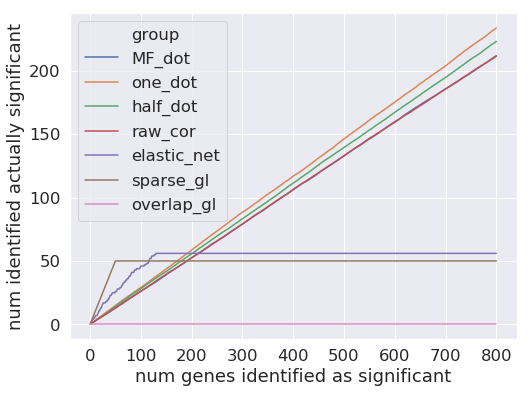

In [55]:
sns.lineplot(x='num genes identified as significant', y='num identified actually significant', hue='group', 
             data=pd.concat([im_dot_df, one_dot_df, half_dot_df, raw_cor_df, elastic_net_df, sparse_gl_df, overlap_gl_df]), ci=None)